In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import pathlib

import matplotlib.pyplot as plt

import torch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!git clone https://github.com/thuml/Transolver.git

In [4]:
dataset_paths = [
    str(path) for path in
    pathlib.Path('drive/MyDrive/Datasets/cityair/processed_data').glob("*")
]

In [5]:
from tqdm import tqdm

In [6]:
def parse_data(dataset_paths):
    data = []
    for p in tqdm(dataset_paths):
        for source in range(10):
            subset = xr.open_dataset(p)['CONC'][:, 0, source, :, :]
            subset = np.array(subset)
            data.append(subset)
    return np.array(data)

In [8]:
data = parse_data(dataset_paths)

100%|██████████| 20/20 [00:27<00:00,  1.38s/it]


In [9]:
data = np.transpose(data, (0, 2, 3, 1))

In [41]:
T_in = 10
T = 8
h = 101
r = 2
ntrain = 150
ntest = 50
step = 1

In [42]:
train_a = data[:ntrain, ::r, ::r, :T_in][:, :h, :h, :]
train_a = train_a.reshape(train_a.shape[0], -1, train_a.shape[-1])
train_a = torch.from_numpy(train_a)
train_u = data[:ntrain, ::r, ::r, T_in:T + T_in][:, :h, :h, :]
train_u = train_u.reshape(train_u.shape[0], -1, train_u.shape[-1])
train_u = torch.from_numpy(train_u)

test_a = data[-ntest:, ::r, ::r, :T_in][:, :h, :h, :]
test_a = test_a.reshape(test_a.shape[0], -1, test_a.shape[-1])
test_a = torch.from_numpy(test_a)
test_u = data[-ntest:, ::r, ::r, T_in:T + T_in][:, :h, :h, :]
test_u = test_u.reshape(test_u.shape[0], -1, test_u.shape[-1])
test_u = torch.from_numpy(test_u)

In [43]:
x = np.linspace(0, 1, h)
y = np.linspace(0, 1, h)
x, y = np.meshgrid(x, y)
pos = np.c_[x.ravel(), y.ravel()]
pos = torch.tensor(pos, dtype=torch.float).unsqueeze(0)
pos_train = pos.repeat(ntrain, 1, 1)
pos_test = pos.repeat(ntest, 1, 1)

In [44]:
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(pos_train, train_a, train_u),
                                           batch_size=8,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(pos_test, test_a, test_u),
                                          batch_size=8,
                                          shuffle=True)

In [18]:
!cp -r Transolver/PDE-Solving-StandardBenchmark TransolverPDE

In [ ]:
!cat Transolver/PDE-Solving-StandardBenchmark/requirements.txt

In [20]:
!pip install torch h5py dgl einops scipy timm

In [22]:
from TransolverPDE.model.Transolver_Structured_Mesh_2D import Model as Transolver_Structured_Mesh_2D

In [45]:
tmodel = Transolver_Structured_Mesh_2D(space_dim=2,
                                       n_layers=3,
                                       n_hidden=64,
                                       dropout=0,
                                       n_head=4,
                                       Time_Input=False,
                                       mlp_ratio=1,
                                       fun_dim=T_in,
                                       out_dim=1,
                                       slice_num=32,
                                       ref=8,
                                       unified_pos=1,
                                       H=h,
                                       W=h).cuda()

In [46]:
optimizer = torch.optim.AdamW(tmodel.parameters())

In [26]:
from TransolverPDE.utils.testloss import TestLoss

In [47]:
myloss = TestLoss(size_average=False)

In [48]:
for ep in range(20):
    tmodel.train()
    train_l2_step = 0
    train_l2_full = 0

    for x, fx, yy in train_loader:
        loss = 0
        x, fx, yy = x.cuda(), fx.cuda(), yy.cuda()
        bsz = x.shape[0]

        for t in range(0, T, step):
            y = yy[..., t:t + step]
            im = tmodel(x, fx=fx)
            loss += myloss(im.reshape(bsz, -1), y.reshape(bsz, -1))
            if t == 0:
                pred = im
            else:
                pred = torch.cat((pred, im), -1)
            fx = torch.cat((fx[..., step:], y), dim=-1)

        train_l2_step += loss.item()
        train_l2_full += myloss(pred.reshape(bsz, -1), yy.reshape(bsz, -1)).item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    test_l2_step = 0
    test_l2_full = 0

    tmodel.eval()

    with torch.no_grad():
        for x, fx, yy in test_loader:
            loss = 0
            x, fx, yy = x.cuda(), fx.cuda(), yy.cuda()
            bsz = x.shape[0]
            for t in range(0, T, step):
                y = yy[..., t:t + step]
                im = tmodel(x, fx=fx)
                loss += myloss(im.reshape(bsz, -1), y.reshape(bsz, -1))
                if t == 0:
                    pred = im
                else:
                    pred = torch.cat((pred, im), -1)
                fx = torch.cat((fx[..., step:], im), dim=-1)

            test_l2_step += loss.item()
            test_l2_full += myloss(pred.reshape(bsz, -1), yy.reshape(bsz, -1)).item()

    print(f"Epoch {ep}")
    print(f"train_step_loss = {train_l2_step / ntrain / (T / step):.5f}, train_full_loss = {train_l2_full / ntrain:.5f}")
    print(f"test_step_loss = {test_l2_step / ntest / (T / step):.5f}, test_full_loss = {test_l2_full / ntest:.5f}")

Epoch 0
train_step_loss = 0.99090, train_full_loss = 0.99120
test_step_loss = 0.98823, test_full_loss = 0.98954
Epoch 1
train_step_loss = 0.98326, train_full_loss = 0.98389
test_step_loss = 0.98849, test_full_loss = 0.99038
Epoch 2
train_step_loss = 0.97639, train_full_loss = 0.97727
test_step_loss = 1.05662, test_full_loss = 1.06646
Epoch 3
train_step_loss = 0.96844, train_full_loss = 0.96965
test_step_loss = 1.12965, test_full_loss = 1.15851
Epoch 4
train_step_loss = 0.95997, train_full_loss = 0.96153
test_step_loss = 0.99577, test_full_loss = 1.00645
Epoch 5
train_step_loss = 0.95095, train_full_loss = 0.95281
test_step_loss = 0.97565, test_full_loss = 0.98089
Epoch 6
train_step_loss = 0.94192, train_full_loss = 0.94412
test_step_loss = 0.97637, test_full_loss = 0.98087
Epoch 7
train_step_loss = 0.93462, train_full_loss = 0.93691
test_step_loss = 0.99048, test_full_loss = 0.99732
Epoch 8
train_step_loss = 0.92375, train_full_loss = 0.92649
test_step_loss = 1.05085, test_full_loss = 

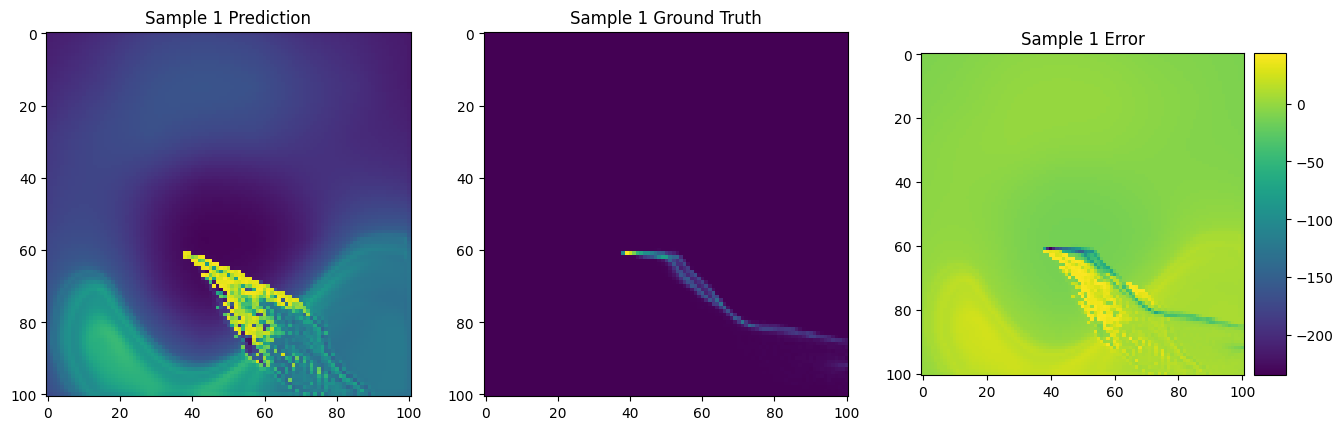

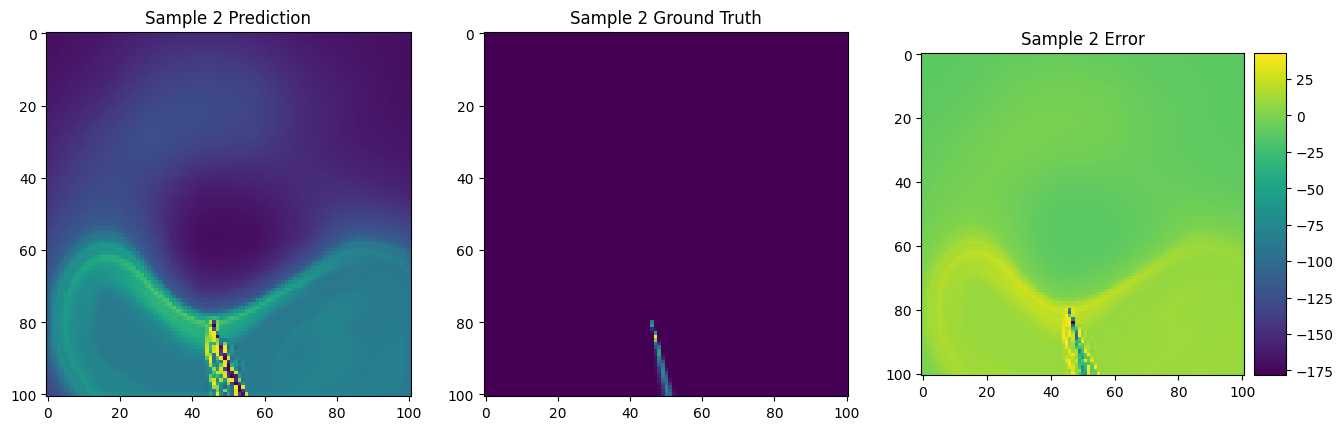

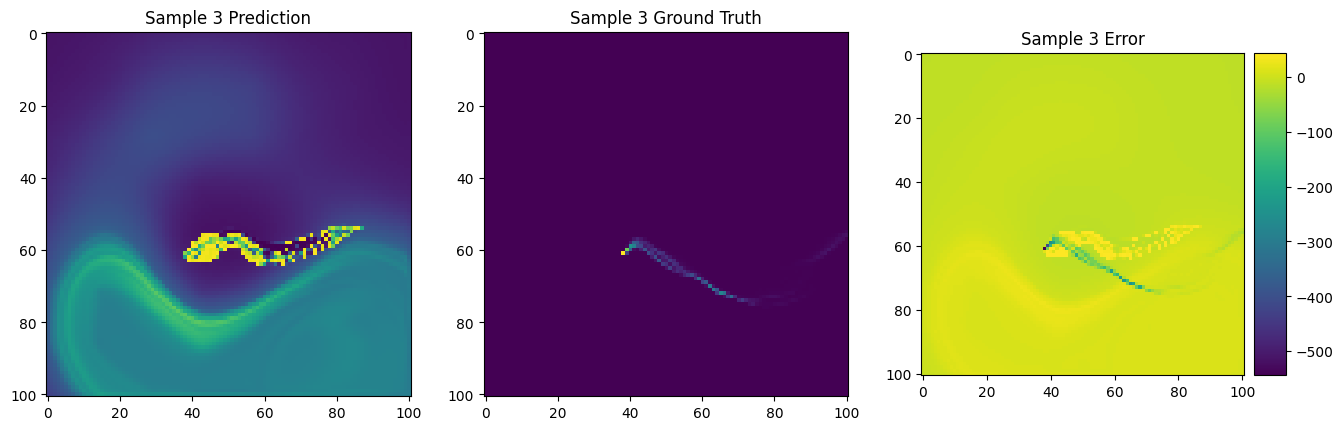

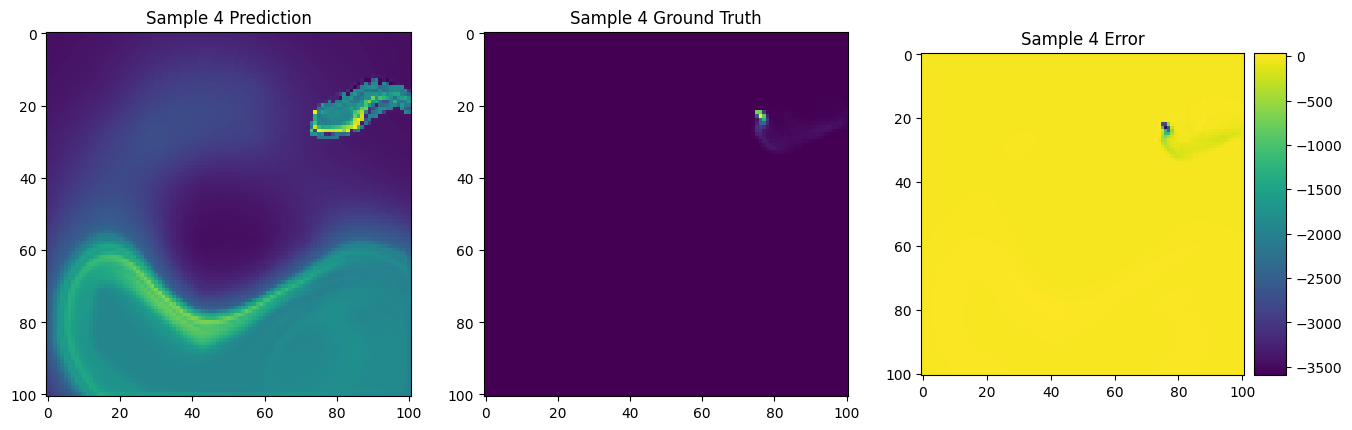

In [62]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

tmodel.eval()
showcase = 5
id = 0

with torch.no_grad():
    for x, fx, yy in train_loader:
        id += 1
        x, fx, yy = x.cuda(), fx.cuda(), yy.cuda()  # x : B, 4096, 2  fx : B, 4096  y : B, 4096, T
        bsz = x.shape[0]
        for t in range(0, T, step):
            im = tmodel(x, fx=fx)

            fx = torch.cat((fx[..., step:], im), dim=-1)
            if t == 0:
                pred = im
            else:
                pred = torch.cat((pred, im), -1)

        if id < showcase:
            fig, ax = plt.subplots(ncols=3, figsize=(16, 5))
            plt.title(id)

            ax[0].imshow(im[0, :, 0].reshape(h, h).detach().cpu().numpy())
            ax[0].set_title(f"Sample {id} Prediction")

            ax[1].imshow(yy[0, :, t].reshape(h, h).detach().cpu().numpy())
            # ax[1].colorbar()
            ax[1].set_title(f"Sample {id} Ground Truth")

            im = ax[2].imshow((im[0, :, 0].reshape(h, h) - yy[0, :, t].reshape(h, h)).detach().cpu().numpy())
            # ax[2].colorbar()
            ax[2].set_title(f"Sample {id} Error")
            divider = make_axes_locatable(ax[2])
            cax = divider.append_axes('right', size='10%', pad=0.1)
            fig.colorbar(im, cax=cax, orientation='vertical')

            plt.show()

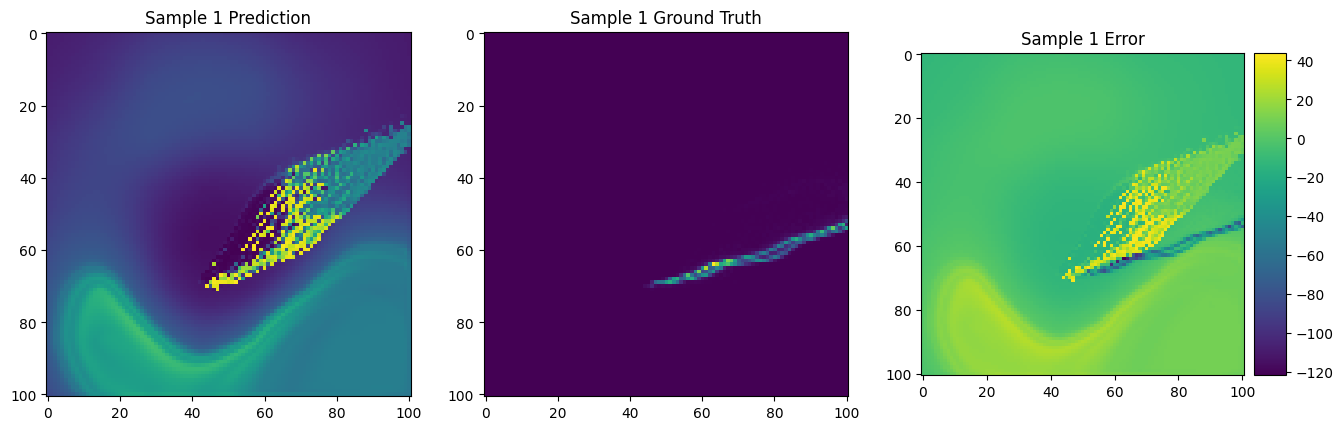

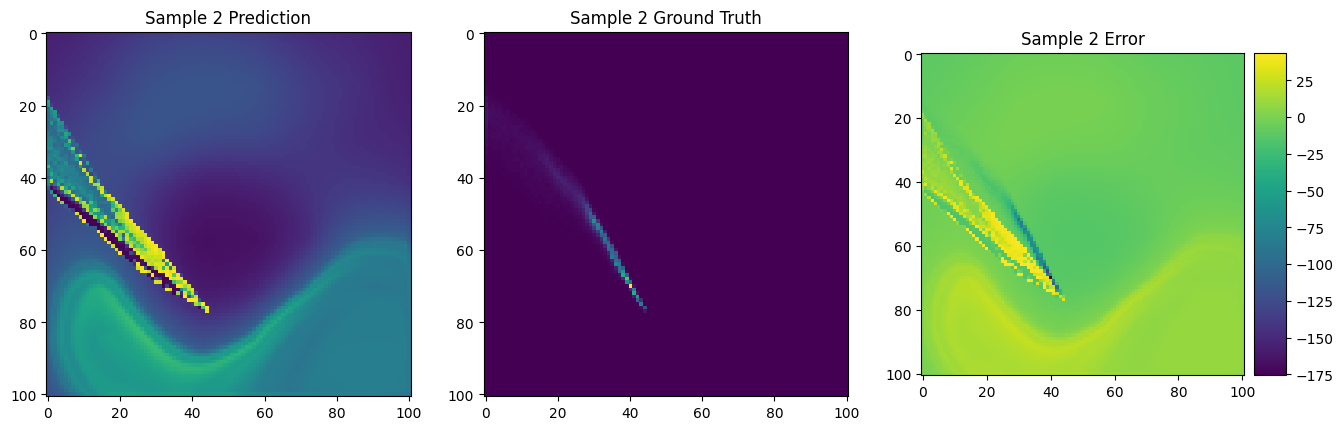

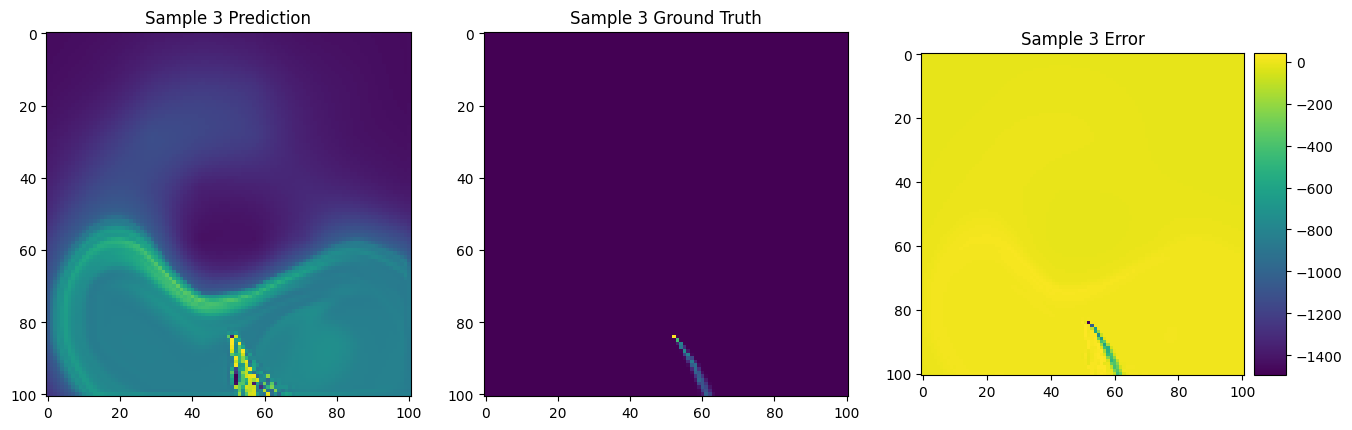

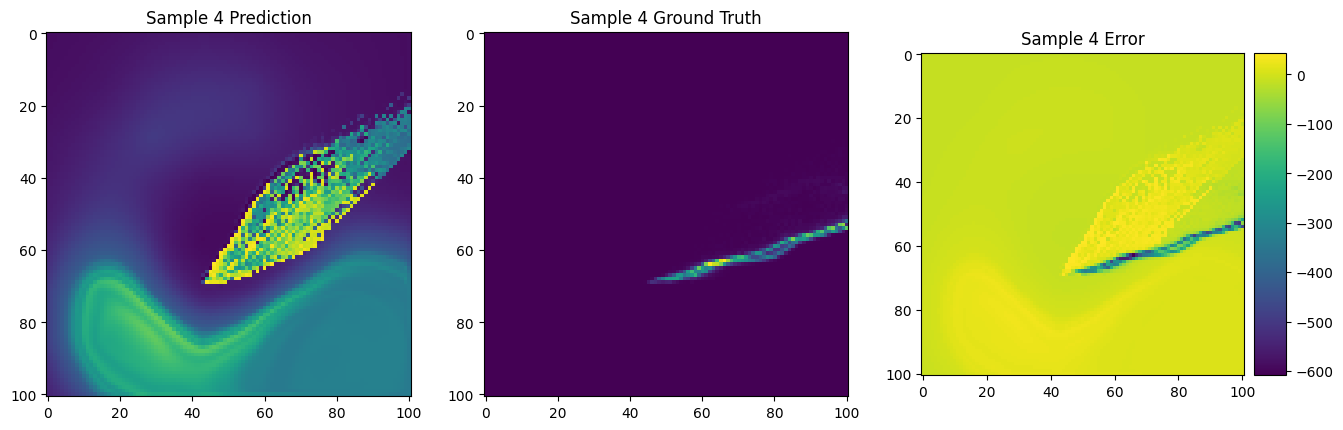

In [63]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

tmodel.eval()
showcase = 5
id = 0

with torch.no_grad():
    for x, fx, yy in test_loader:
        id += 1
        x, fx, yy = x.cuda(), fx.cuda(), yy.cuda()  # x : B, 4096, 2  fx : B, 4096  y : B, 4096, T
        bsz = x.shape[0]
        for t in range(0, T, step):
            im = tmodel(x, fx=fx)

            fx = torch.cat((fx[..., step:], im), dim=-1)
            if t == 0:
                pred = im
            else:
                pred = torch.cat((pred, im), -1)

        if id < showcase:
            fig, ax = plt.subplots(ncols=3, figsize=(16, 5))
            plt.title(id)

            ax[0].imshow(im[0, :, 0].reshape(h, h).detach().cpu().numpy())
            ax[0].set_title(f"Sample {id} Prediction")

            ax[1].imshow(yy[0, :, t].reshape(h, h).detach().cpu().numpy())
            # ax[1].colorbar()
            ax[1].set_title(f"Sample {id} Ground Truth")

            im = ax[2].imshow((im[0, :, 0].reshape(h, h) - yy[0, :, t].reshape(h, h)).detach().cpu().numpy())
            # ax[2].colorbar()
            ax[2].set_title(f"Sample {id} Error")
            divider = make_axes_locatable(ax[2])
            cax = divider.append_axes('right', size='10%', pad=0.1)
            fig.colorbar(im, cax=cax, orientation='vertical')

            plt.show()